In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


In [10]:
# if you don't have dowhy installed, uncomment the following line
!pip install dowhy

   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 1.1/1.1 MB 5.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/989.5 kB ? eta -:--:--
   ---------------------------------------- 989.5/989.5 kB 6.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/742.5 kB ? eta -:--:--
   ---------------------------------------- 742.5/742.5 kB 5.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/7.4 MB ? eta -:--:--
   ------------------------------- -------- 5.8/7.4 MB 25.1 MB/s eta 0:00:01
   ---------------------------------------  7.3/7.4 MB 26.6 MB/s eta 0:00:01
   ---------------------------------------- 7.4/7.4 MB 12.8 MB/s eta 0:00:00


### Creating a psudo relational graph on fast food and weight gain

In [28]:
import networkx as nx

causal_graph = nx.DiGraph([('Education', 'Income'),
                           ('Income', 'Fast_Food'),
                           ('Fast_Food', 'Weight_Gain'),
                           ('Fast_Food', 'Health'),
                           ('Exercise', 'Health'),
                           ('Stress', 'Fast_Food'),
                           ('Stress', 'Health'),
                           ('Stress', 'Weight_Gain'),
                           ('Weight_Gain', 'Exercise'),
                           ('Education', 'Stress')
                           ])

#### Let's visiualize the graph 

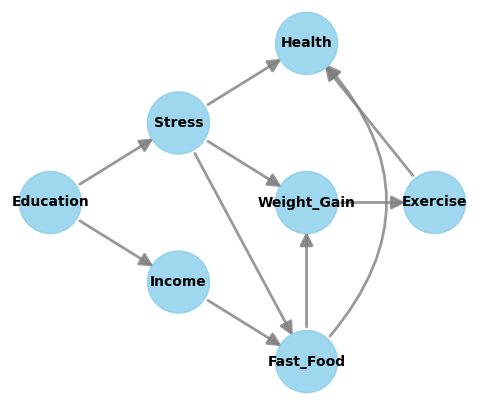

In [29]:
from dowhy.utils import plot

plot(causal_graph)

#### We are generating a data set and would test the relationship as well.

In [15]:
# Step 1: Generate a synthetic dataset with a causal structure
np.random.seed(42)

# Define the number of samples
n = 500  

# Simulated causal relationships
education = np.random.randint(10, 20, n)  # Years of education
income = education * 2000 + np.random.normal(0, 5000, n)  # Higher education → higher income
exercise = np.random.randint(0, 10, n)  # Hours of exercise per week
health = income * 0.0005 + exercise * 1.5 + np.random.normal(0, 5, n)  # Income & exercise → health
stress = 50 - 0.01 * income + np.random.normal(0, 3, n)  # Higher income → lower stress
fast_food = np.random.randint(1, 5, n) + stress * 0.2 + np.random.normal(0, 1, n)  # Stress increases fast food consumption
weight_gain = fast_food * 3 - exercise * 1.2 + np.random.normal(0, 2, n)  # Fast food ↑, exercise ↓ affects weight gain

# Create a DataFrame
data = pd.DataFrame({
    'Education': education,
    'Income': income,
    'Exercise': exercise,
    'Health': health,
    'Stress': stress,
    'Fast_Food': fast_food,
    'Weight_Gain': weight_gain
})


In [16]:
data.head()

,Education,Income,Exercise,Health,Stress,Fast_Food,Weight_Gain
0,16,38527.394036,8,34.353841,-329.788160,-63.537087,-201.597229
1,13,26105.019208,1,15.257693,-204.993294,-40.301614,-120.503347
2,17,37409.764856,0,21.234582,-324.903053,-63.400557,-187.725196
3,14,26448.666217,9,31.676100,-216.577481,-39.304420,-130.467245
4,16,33620.831762,1,9.055714,-288.492704,-57.187691,-176.467727


In [30]:
from dowhy import gcm
gcm.util.general.set_random_seed(0)

# Create the structural causal model object
scm = gcm.StructuralCausalModel(causal_graph)

# Automatically assign generative models to each node based on the given data
auto_assignment_summary = gcm.auto.assign_causal_mechanisms(scm, data)



In [31]:
print(auto_assignment_summary)

When using this auto assignment function, the given data is used to automatically assign a causal mechanism to each node. Note that causal mechanisms can also be customized and assigned manually.
The following types of causal mechanisms are considered for the automatic selection:

If root node:
An empirical distribution, i.e., the distribution is represented by randomly sampling from the provided data. This provides a flexible and non-parametric way to model the marginal distribution and is valid for all types of data modalities.

If non-root node and the data is continuous:
Additive Noise Models (ANM) of the form X_i = f(PA_i) + N_i, where PA_i are the parents of X_i and the unobserved noise N_i is assumed to be independent of PA_i.To select the best model for f, different regression models are evaluated and the model with the smallest mean squared error is selected.Note that minimizing the mean squared error here is equivalent to selecting the best choice of an ANM.

If non-root node

In [32]:
gcm.fit(scm, data)

Fitting causal mechanism of node Stress: 100%|██████████| 7/7 [00:00<00:00, 330.27it/s]


In [33]:
print(gcm.evaluate_causal_model(scm, data, compare_mechanism_baselines=True, evaluate_invertibility_assumptions=False, evaluate_causal_structure=False))

Evaluating causal mechanisms...: 100%|██████████| 7/7 [00:00<00:00, 3443.60it/s]


Evaluated the performance of the causal mechanisms and the overall average KL divergence between generated and observed distribution. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the underlying classifier model.
- (normalized) Continuous Ranked Probability Score (CRPS):

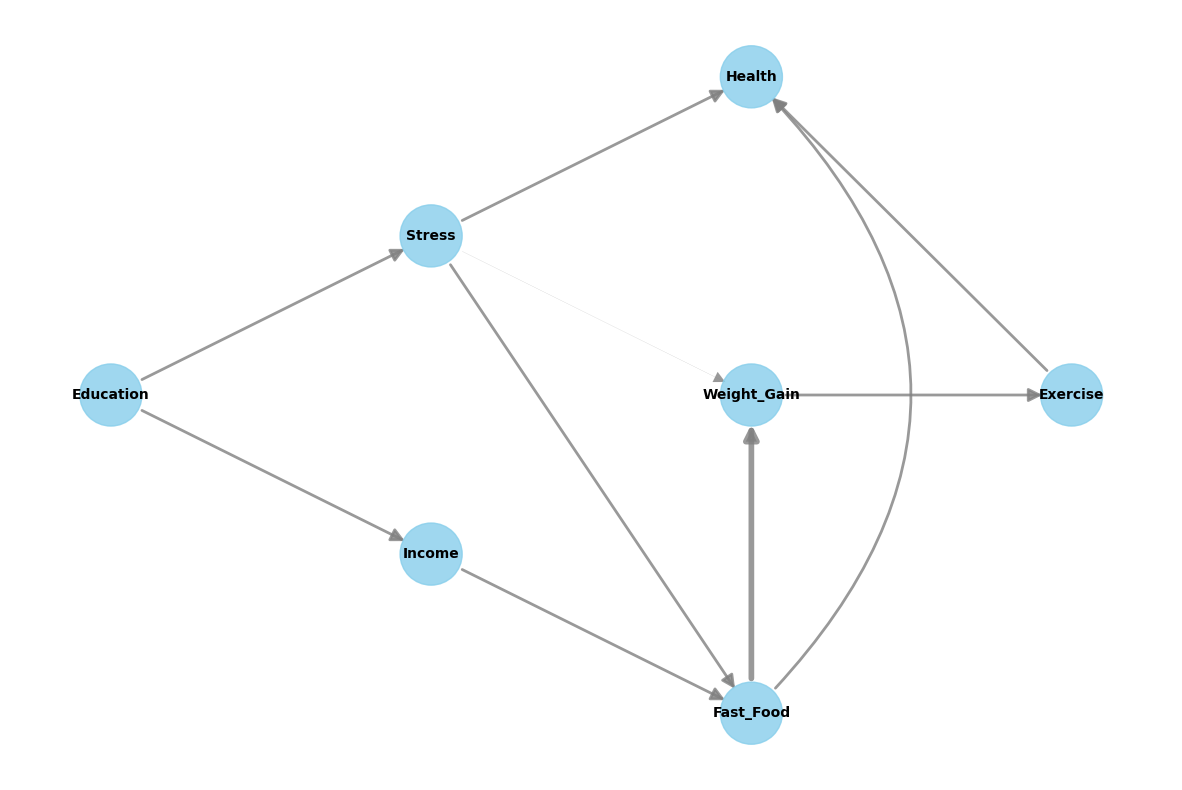

In [34]:
import numpy as np

# Note: The percentage conversion only makes sense for purely positive attributions.
def convert_to_percentage(value_dictionary):
    total_absolute_sum = np.sum([abs(v) for v in value_dictionary.values()])
    return {k: abs(v) / total_absolute_sum * 100 for k, v in value_dictionary.items()}


arrow_strengths = gcm.arrow_strength(scm, target_node='Weight_Gain')

plot(causal_graph,
     causal_strengths=convert_to_percentage(arrow_strengths),
     figure_size=[15, 10])

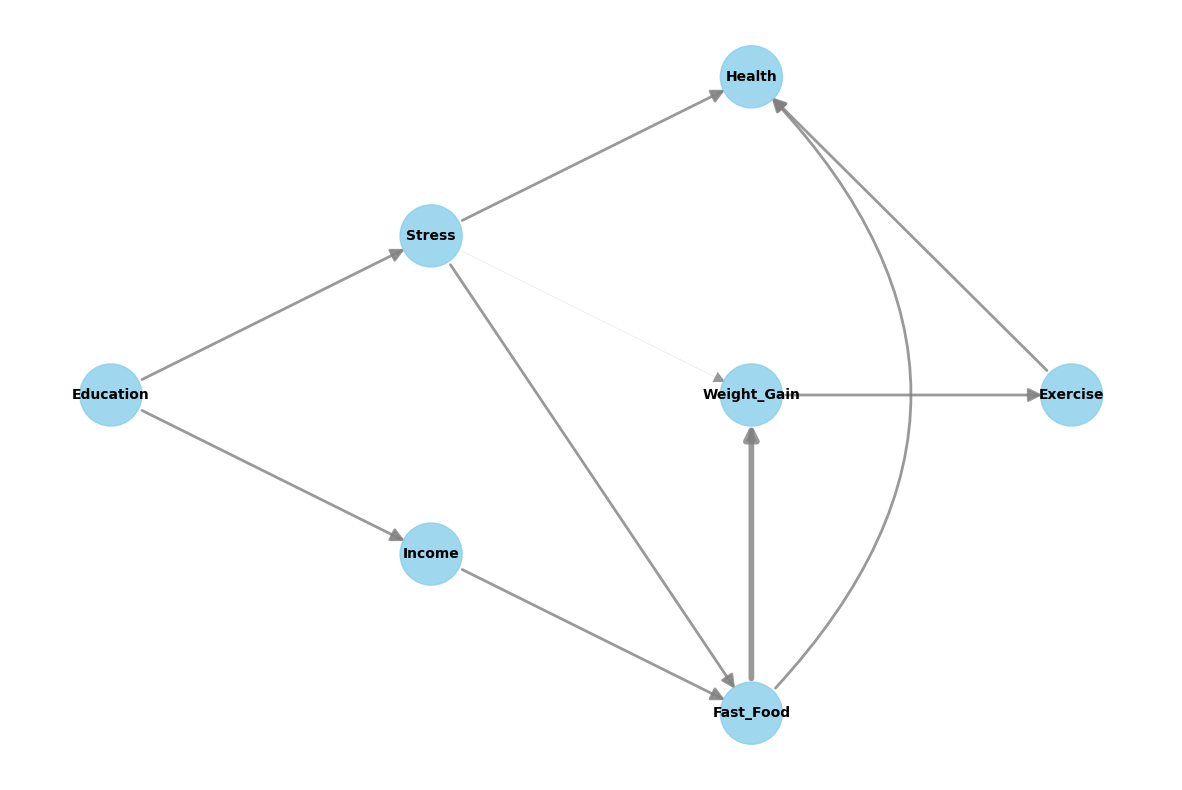

In [37]:
import numpy as np

# Note: The percentage conversion only makes sense for purely positive attributions.
def convert_to_percentage(value_dictionary):
    total_absolute_sum = np.sum([abs(v) for v in value_dictionary.values()])
    return {k: abs(v) / total_absolute_sum * 100 for k, v in value_dictionary.items()}


arrow_strengths = gcm.arrow_strength(scm, target_node='Weight_Gain')

plot(causal_graph,
     causal_strengths=convert_to_percentage(arrow_strengths),
     figure_size=[15, 10])

In [35]:
arrow_strengths

{('Fast_Food', 'Weight_Gain'): 2220.810891849939,
 ('Stress', 'Weight_Gain'): 1.3638185189061367}

#### Now , I hope you have a pretty good idea on how to generate a causal graph based on any data

Reference: https://www.pywhy.org/dowhy/v0.8/getting_started/intro.html

In [41]:
from dowhy import CausalModel
import dowhy
dataset=data

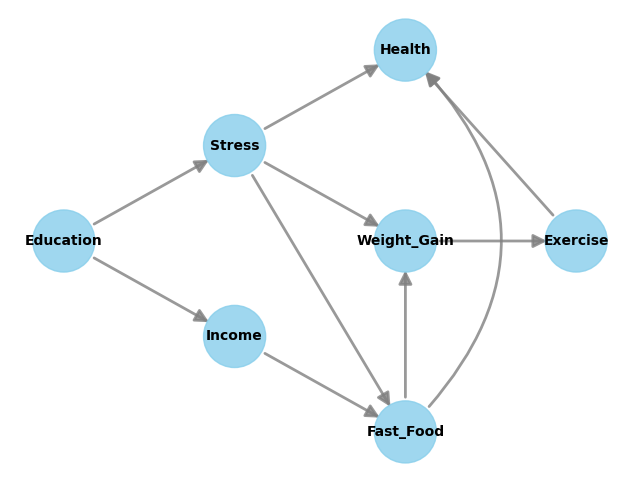

In [44]:
from dowhy import CausalModel
import networkx as nx

# Convert the NetworkX graph to a DOT format string
dot_graph = nx.nx_pydot.to_pydot(causal_graph).to_string()

model = CausalModel(
        data=dataset,
        graph=dot_graph,
        treatment="Fast_Food",
        outcome='Weight_Gain')
model.view_model()


In [45]:
#Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                             
────────────(E[Weight_Gain|Stress])
d[Fast_Food]                       
Estimand assumption 1, Unconfoundedness: If U→{Fast_Food} and U→Weight_Gain then P(Weight_Gain|Fast_Food,Stress,U) = P(Weight_Gain|Fast_Food,Stress)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



### Estimations does not work untill the treatment is binary , hence checnging the data set to set a binary flag

In [48]:
# Convert the "Fast_Food" variable to a binary treatment
dataset['Fast_Food_Binary'] = (dataset['Fast_Food'] > dataset['Fast_Food'].median()).astype(int)

#### once we have created the binary flar. we need to recreate the graph again

In [49]:
import networkx as nx

causal_graph = nx.DiGraph([('Education', 'Income'),
                           ('Income', 'Fast_Food_Binary'),
                           ('Fast_Food_Binary', 'Weight_Gain'),
                           ('Fast_Food_Binary', 'Health'),
                           ('Exercise', 'Health'),
                           ('Stress', 'Fast_Food_Binary'),
                           ('Stress', 'Health'),
                           ('Stress', 'Weight_Gain'),
                           ('Weight_Gain', 'Exercise'),
                           ('Education', 'Stress')
                           ])

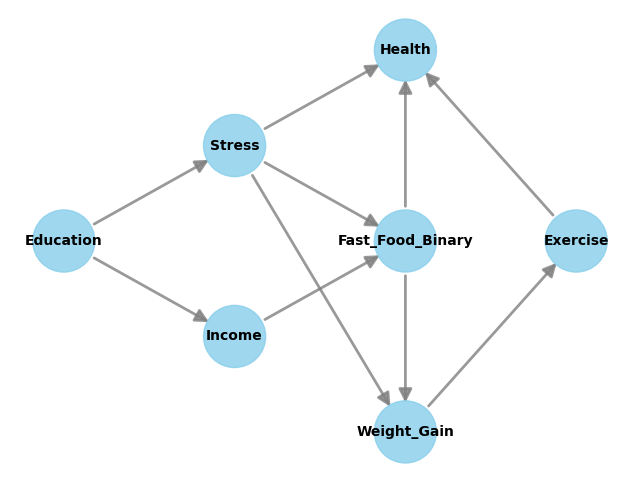

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                
───────────────────(E[Weight_Gain|Stress])
d[Fast_Food_Binary]                       
Estimand assumption 1, Unconfoundedness: If U→{Fast_Food_Binary} and U→Weight_Gain then P(Weight_Gain|Fast_Food_Binary,Stress,U) = P(Weight_Gain|Fast_Food_Binary,Stress)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                
───────────────────(E[Weight_Gain|Stress])
d[Fast_Food_Binary]                       
Estimand assumption 1, Unconfoundedness: If U→{Fast_Food_Binary} and U→Weight_Gain then P(Weight_Gain|Fast_Food_Binary,Stress,U) = P(Weight_Gain|Fast_Food_Binary,Stress)

#

In [50]:
# Convert the NetworkX graph to a DOT format string
dot_graph = nx.nx_pydot.to_pydot(causal_graph).to_string()

# Update the model with the binary treatment
model = CausalModel(
        data=dataset,
        graph=dot_graph,
        treatment="Fast_Food_Binary",
        outcome='Weight_Gain')
model.view_model()

# Identify the causal effect with the binary treatment
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

# Estimate the effect using propensity score weighting
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_weighting", target_units="ate")
# ATE = Average Treatment Effect
# ATT = Average Treatment Effect on Treated (i.e. those who were assigned a different room)
# ATC = Average Treatment Effect on Control (i.e. those who were not assigned a different room)
print(estimate)

### Refute result: 

In the context of causal inference and causal discovery, the refute_result is important because it helps validate the robustness and reliability of the causal relationships identified by your model. Here are a few key reasons why refute_result is crucial:

Validation of Causal Claims: Refutation tests help ensure that the causal relationships you have discovered are not spurious. They provide evidence that the identified causal effect is not due to random chance or confounding variables.

Robustness Check: By performing refutation tests, you can check the stability of your causal findings under various assumptions and perturbations. This helps in understanding whether the causal effect holds under different scenarios.

Bias Detection: Refutation methods can help detect biases in your causal model. For example, they can identify if there are hidden confounders that were not accounted for in the initial analysis.

Model Confidence: A strong refutation result increases confidence in your causal model. It indicates that the model's predictions are reliable and can be trusted for decision-making.

Scientific Rigor: In scientific research, it is essential to validate findings through multiple methods. Refutation results add an extra layer of rigor to your causal analysis, making your conclusions more credible.

In summary, refute_result is a critical component of causal analysis as it helps ensure that the causal relationships identified are valid, reliable, and robust.



In [ ]:

# Method 1: Random Common Cause:- Adds randomly drawn covariates to data and re-runs the analysis to see if the causal estimate changes or not. If our assumption was originally correct then the causal estimate shouldn’t change by much.
refute1_results=model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute1_results)

Refute: Add a random common cause
Estimated effect:65.46613583428737
New effect:65.46613583428736
p value:1.0



Refute 1: Add a Random Common Cause

Original Estimated Effect: 65.46613583428737
New Effect (Random Common Cause): 65.46613583428736
p-value: 1.0
Interpretation:

This refutation test introduces a random variable that acts as a common cause (confounder) between the treatment and outcome.
The purpose is to see if your estimated effect changes when a potential confounder is added.
In this case, the new effect (65.47) is virtually identical to the original effect (65.47).
The p-value of 1.0 indicates that there is no statistically significant difference between the original and new effects.
This result suggests that your causal estimate is robust to the addition of a random common cause. It implies that the presence of such a confounder, at least in its random form, does not significantly alter the estimated causal relationship.

In [53]:
# method 2:Placebo Treatment Refuter:- Randomly assigns any covariate as a treatment and re-runs the analysis. If our assumptions were correct then this newly found out estimate should go to 0.
refute2_results=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter")
print(refute2_results)

Refute: Use a Placebo Treatment
Estimated effect:65.46613583428737
New effect:-70.81155605305437
p value:0.0



Refute 2: Use a Placebo Treatment

Original Estimated Effect: 65.46613583428737
New Effect (Placebo): -70.81155605305437
p-value: 0.0
Interpretation:

This refutation test substitutes the actual treatment with a placebo (a fake treatment that shouldn't have any effect).
Ideally, with a placebo, the estimated effect should be close to zero.
In this case, the new effect is -70.81, which is significantly different from both the original effect (65.47) and zero.
The p-value of 0.0 indicates that this difference is statistically highly significant.
This result strongly suggests that your original causal estimate is not robust. It implies that the observed effect might be due to factors other than the true causal relationship between the treatment and outcome. There could be unobserved confounders or other issues with your model.

### Overall Summary

The "placebo treatment" refutation raises serious concerns about the validity of your original causal estimate. It indicates that the observed effect might not be a true causal effect.
The "add random common cause" refutation shows that the estimate is stable under that specific test.
Therefore, your model is robust to random common causes, but very non robust to placebo treatments. This means that although the model is stable under the addition of random noise, it is very sensitive to the treatment variable itself. This indicates that there are likely other factors that are affecting the outcome, and that are highly correlated to the treatment variable.


#### Key Takeaways

A p-value close to 0 indicates strong evidence against the null hypothesis (that there is no difference).
A p-value close to 1 indicates strong evidence in favor of the null hypothesis (that there is no difference).
Refutation tests are vital for assessing the reliability of causal inference results.
The placebo test result should be investigated. You should look for possible unobserved confounders, or if the treatment variable is acting as a proxy for another variable.